In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout

# 
from scipy.stats import ttest_ind
from itertools import combinations

# Entrenamiento
from sklearn.model_selection import RandomizedSearchCV


# Funciones Personalizadas
from utils.synthetic_features import temporada_alta
from utils.synthetic_features import periodo_dia

# Configuración General
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 8})

In [118]:
# IMPORTAR DATOS
df = pd.read_csv('../data/dataset_SCL.csv')

# Transformar variables de fecha de string a datetime para cálculo de nuevas variables
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# Agregar Variable Fecha
df['fecha'] = df['Fecha-I'].dt.date

# Nuevas Variables: Temporada
df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)
df['temporada_alta_enriched'] = df['Fecha-I'].apply(temporada_alta, enriched=True)

# Nuevas Variables: Atraso en Minutos
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']).apply(lambda x: x.total_seconds() / 60)
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x>15 else 0)

# Nuevas Variables: Periodo del Día (mañana, tarde, noche)
df['periodo_dia'] = df['Fecha-I'].apply(periodo_dia)

# Dia de la semana en formato numérico (1: Lunes, 7: Domingo)
df['SEMANA'] = df['Fecha-O'].dt.strftime('%Y%W')
df['DOW'] = df['Fecha-O'].dt.dayofweek + 1

/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_12007/1943184977.py:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/dataset_SCL.csv')


In [119]:
# Definición de Variable Dependiente
y = df.atraso_15

# Definición de Variables Independientes
X_columns = ['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'temporada_alta_enriched', 'periodo_dia']
X = df[X_columns]

print('y:', y.shape)
print('X:', X.shape)

y: (68206,)
X: (68206, 7)


In [120]:
X.head()

,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta_enriched,periodo_dia
0,1,Domingo,I,American Airlines,Miami,1,noche
1,1,Lunes,I,American Airlines,Miami,1,noche
2,1,Martes,I,American Airlines,Miami,1,noche
3,1,Miercoles,I,American Airlines,Miami,1,noche
4,1,Jueves,I,American Airlines,Miami,1,noche


In [121]:
# Dividir Datos en Set de Entreamiento y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=20230214)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


print(f'Tamaño X_train: {X_train.shape}')
print(f'Tamaño y_train: {y_train.shape}')
print(f'Tamaño X_test: {X_test.shape}')
print(f'Tamaño y_test: {y_test.shape}')

Tamaño X_train: (47744, 7)
Tamaño y_train: (47744,)
Tamaño X_test: (20462, 7)
Tamaño y_test: (20462,)


### Pool de Modelos

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    
    'LogisticRegression'     : {'model':LogisticRegression(max_iter=1000),
                                'grid_param':{
                                    'penalty':['l1', 'l2'],
                                    'solver':['liblinear'],
                                    'C':np.logspace(-3,3,7),
                                    'fit_intercept':[True, False],
                                    'random_state':[20230214]
                                },
                                'results':{
                                    'best_params':[],
                                    'select_features_criterion':[],
                                    'n_features':[],
                                    'train_roc_auc_score':[],
                                    'val_roc_auc_score':[]
                                }
                               },
    

    
    'DecisionTreeClassifier' : {'model':DecisionTreeClassifier(),
                                'grid_param':{
                                    'criterion':['gini', 'entropy'],
                                    'max_depth':[2,5,10],
                                    'max_features':['sqrt'],
                                    'random_state':[20230214]
                                },
                                'results':{
                                    'best_params':[],
                                    'select_features_criterion':[],
                                    'n_features':[],
                                    'train_roc_auc_score':[],
                                    'val_roc_auc_score':[]
                                }
                               },
    'RandomForestClassifier' : {'model':RandomForestClassifier(),
                                'grid_param':{
                                    'n_estimators':[100],
                                    'criterion':['gini', 'entropy'],
                                    'max_depth':[2,5,10],
                                    'max_features':['sqrt'],
                                    'random_state':[20230214]
                                },
                                'results':{
                                    'best_params':[],
                                    'select_features_criterion':[],
                                    'n_features':[],
                                    'train_roc_auc_score':[],
                                    'val_roc_auc_score':[]
                                }
                               }
    
}

### Cross Validation (Personalizado)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score


skfolds = StratifiedKFold(n_splits=30, shuffle=True, random_state=20230214)

for train_index, val_index in tqdm(skfolds.split(X_train, y_train)):
    
    # Seleccionar Datos de Entrenamiento y Validación
    X_train_folds = X_train.iloc[train_index,:]
    y_train_folds = y_train[train_index]
    X_val_folds = X_train.iloc[val_index,:]
    y_val_folds = y_train[val_index]
    
    
    ## TRATAMIENTO DE VARIABLES CATEGÓRICAS
    # Genera Variables Dummy por cada categoría y elimina la primera categoría de cada variable
    # La eliminación de la primera categoría se ha para evitar problemas de multicolinealidad.
    encoder = OneHotEncoder(drop='first', sparse_output=False, min_frequency=100, handle_unknown='infrequent_if_exist')
    encoder.fit(X_train_folds)
    
    # Transformación de matrix X -> Dummies
    X_train_folds = encoder.transform(X_train_folds)
    X_val_folds = encoder.transform(X_val_folds)
    
    # Renombrar Columnas (para interpretabilidad)
    X_train_folds = pd.DataFrame(X_train_folds, columns=encoder.get_feature_names_out())
    X_val_folds = pd.DataFrame(X_val_folds, columns=encoder.get_feature_names_out())
    
    ## SELECCIÓN DE VARIABLES
    for features_criterion in ['kbest', 'pvalue']:
        
        if features_criterion == 'kbest':
            
            for i in [10,30,50]:
           
                chi2_features = SelectKBest(chi2, k=i)
                X_train_folds_kbest = chi2_features.fit_transform(X_train_folds, y_train_folds)   
                X_val_folds_kbest = chi2_features.transform(X_val_folds)   


                ## ENTRENAMIENTO DE MODELOS

                for classifier in models.keys():

                    print(classifier)

                    clf = models[classifier]['model']
                    best_param_clf = RandomizedSearchCV(clf, models[classifier]['grid_param'])

                    best_param_clf.fit(X_train_folds_kbest, y_train_folds)
                    models[classifier]['results']['best_params'].append(best_param_clf.best_params_)

                    predict_y_train = best_param_clf.predict_proba(X_train_folds_kbest)[:,1]
                    predict_y_val = best_param_clf.predict_proba(X_val_folds_kbest)[:,1]

                    train_score = roc_auc_score(y_train_folds, predict_y_train)
                    val_score = roc_auc_score(y_val_folds, predict_y_val)
                    
                    models[classifier]['results']['select_features_criterion'].append(features_criterion)
                    models[classifier]['results']['n_features'].append(i)
                    models[classifier]['results']['train_roc_auc_score'].append(train_score)
                    models[classifier]['results']['val_roc_auc_score'].append(val_score)

                    print(train_score, val_score)
        
        
        elif features_criterion == 'pvalue':

            chi2_features = SelectKBest(chi2, k=50)
            chi2_features.fit(X_train_folds, y_train_folds)

            chi2_results = pd.DataFrame({'variable' : chi2_features.feature_names_in_,
                                         'score'    : chi2_features.scores_,
                                         'pvalue'   : chi2_features.pvalues_})

            chi2_results.set_index('variable', inplace=True)

            variables_significativas = list(chi2_results.query('pvalue < 0.05').index)

            X_train_folds_pvalue = X_train_folds[variables_significativas]
            X_val_folds_pvalue = X_val_folds[variables_significativas]
            
            ## ENTRENAMIENTO DE MODELOS
            for classifier in models.keys():

                print(classifier)

                clf = models[classifier]['model']
                best_param_clf = RandomizedSearchCV(clf, models[classifier]['grid_param'])

                best_param_clf.fit(X_train_folds_pvalue, y_train_folds)
                models[classifier]['results']['best_params'].append(best_param_clf.best_params_)

                predict_y_train = best_param_clf.predict_proba(X_train_folds_pvalue)[:,1]
                predict_y_val = best_param_clf.predict_proba(X_val_folds_pvalue)[:,1]

                train_score = roc_auc_score(y_train_folds, predict_y_train)
                val_score = roc_auc_score(y_val_folds, predict_y_val)

                models[classifier]['results']['select_features_criterion'].append(features_criterion)
                models[classifier]['results']['n_features'].append(len(variables_significativas))
                models[classifier]['results']['train_roc_auc_score'].append(train_score)
                models[classifier]['results']['val_roc_auc_score'].append(val_score)

                print(train_score, val_score)

    


0it [00:00, ?it/s]

LogisticRegression
0.556596592217915 0.5691238113113114
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.622419633435284 0.6346111736736737
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6224182989548146 0.6345746788455122
LogisticRegression
0.6565957542883181 0.6759728478478478
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6351813105079243 0.6411502648481815
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6613074199984778 0.6785092384050717
LogisticRegression
0.6702645304944692 0.6861014660493827
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6286713951240721 0.6400893080580581
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6906737722062012 0.6931475746579914
LogisticRegression
0.6731950139154502 0.6890979521187854
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.660773539362635 0.6585569944944945
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
1it [01:18, 78.58s/it]

0.7011559580169341 0.7006980939272606
LogisticRegression
0.6266970809248353 0.6641524336836836
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6074812744071241 0.6254366345512178
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6279816238935936 0.6674187208041374
LogisticRegression
0.6561507997068178 0.6837110548048048
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6381401268113341 0.6771406823490157
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6613434214884407 0.6857495516349681
LogisticRegression
0.6696296048595572 0.6956683245745746
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6288668127198644 0.6532496037704372
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6890553267068102 0.6953098932265598
LogisticRegression
0.6723757360105908 0.7037519290123457
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6497762394355892 0.6452572364030698
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2it [02:36, 78.37s/it]

0.7022513585515486 0.7075174132465798
LogisticRegression
0.6172999891146738 0.6219774461961961
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6103549430979857 0.6224662162162161
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6179591293632177 0.628710741991992
LogisticRegression
0.658106361352018 0.6589467071237904
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6312791996158558 0.6383818714547882
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6618231842860889 0.6669938167334001
LogisticRegression
0.6700592749845197 0.6634798861361362
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.62642306087768 0.6227907595095095
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6888683442689612 0.675318547714381
LogisticRegression
0.6735926704746429 0.6661062103770438
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6542148518210732 0.6365141182849516
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
3it [03:55, 78.37s/it]

0.7019861165927828 0.6800368076409743
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6223026538083783 0.5978335105939272
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6052402099758467 0.570165217300634
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6229216044706958 0.5923540728228227
LogisticRegression
0.6582556198890659 0.628467008675342
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6327362164266632 0.617827462879546
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6628399296108104 0.625706435602269
LogisticRegression
0.6712133321426458 0.6408361486486487
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6148707955233766 0.591186238321655
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6895979342242335 0.640260051718385
LogisticRegression
0.6752481307381206 0.6397856189522857
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.640694078809296 0.6113379004004005
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
4it [05:14, 78.83s/it]

0.7051671440667098 0.6486773231564897
LogisticRegression
0.6180563245413053 0.5995670149315983
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6112351369328254 0.5975584959959961
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6189132254850701 0.6025491637470803
LogisticRegression
0.6580016480833796 0.6379478436770103
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6325319741908375 0.6149052698531865
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6630188291314913 0.6383101851851852
LogisticRegression
0.6715606415468305 0.6478249082415749
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6328312190223053 0.6155530530530531
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6915672984319622 0.6627512929596263
LogisticRegression
0.6745070409749901 0.650829214631298
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6578775677790001 0.6242401255422089
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
5it [06:34, 79.15s/it]

0.7021751705788022 0.6629011824324325
LogisticRegression
0.6175883175855587 0.6141558224891559
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6110418327816833 0.6031435080914247
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6184803432966525 0.6142653069736402
LogisticRegression
0.6599058632649415 0.6411359275942611
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6319763182475229 0.6332126397230563
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6715983545855814 0.6484244661327995
LogisticRegression
0.6708057011178059 0.6446941733400067
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6298158952296281 0.5996843197364031
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6891205269397858 0.6593468468468469
LogisticRegression
0.6742644277705075 0.6476971763430096
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.5936111018223339 0.589989729312646
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
6it [07:57, 80.41s/it]

0.7029593035439535 0.6675216883550217
LogisticRegression
0.6175961242963042 0.6119465819986654
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6106560468917817 0.6137217947113781
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186029122243144 0.6178769915749082
LogisticRegression
0.6567864018922933 0.6723207582582583
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6320549998366813 0.642013106856857
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6612786665995289 0.6680508633633633
LogisticRegression
0.6702068964554104 0.6851408700367033
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6313809196137672 0.6024370724891558
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6931884346163923 0.6805099370203536
LogisticRegression
0.6729479627875466 0.6866671358858859
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.5760639855454042 0.5945515828328327
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
7it [09:16, 80.09s/it]

0.7030375630648703 0.6899985923423424
LogisticRegression
0.6168842829312732 0.6339659972472472
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6104120712758432 0.6211823802969636
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6182582143673736 0.6286586065231898
LogisticRegression
0.6567675562349682 0.674411390557224
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6318117799091016 0.6430897042876209
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6610641923122907 0.6673652819486152
LogisticRegression
0.670573970136034 0.687082916249583
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6446849636870019 0.6385617388221556
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6916952285573235 0.684400546379713
LogisticRegression
0.6734216552507811 0.6876016641641642
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6158694912238901 0.6227868493493496
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
8it [10:35, 79.82s/it]

0.703461642337355 0.6888450950950951
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6176994736017651 0.6110433350016684
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6107644330851535 0.6109221200367033
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186294668339318 0.6080403319986654
LogisticRegression
0.6587796346797647 0.6304233921421423
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6422307004835397 0.6244421504838171
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6632073788080312 0.6336271167000335
LogisticRegression
0.6706783978879209 0.651046880213547
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6314580091366911 0.5966604625458793
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6893040707628441 0.646899503670337
LogisticRegression
0.6748732767260166 0.6506636845178512
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.650940314507564 0.6049604291791792
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
9it [11:55, 79.76s/it]

0.7016744766101651 0.6393893893893894
LogisticRegression
0.6174723465776124 0.616773023023023
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6102804635705841 0.6252724078244912
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.618410216347991 0.6243769811478146
LogisticRegression
0.657912995132017 0.6690427406573239
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6325458791669831 0.6167508654487821
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6612186025646388 0.6657321383883884
LogisticRegression
0.6705838452915067 0.6780478395061728
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6339443945264266 0.6096995432932932
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6890784287361438 0.6726935268601935
LogisticRegression
0.673041499006394 0.6816712545879213
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6511255931552324 0.6374134551217885
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
10it [13:13, 79.15s/it]

0.7019543823368785 0.673487289372706
LogisticRegression
0.6172068935847257 0.6239703244911579
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6105580215427044 0.6162985902569238
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6184184870234576 0.6240850225225226
LogisticRegression
0.6575289502736112 0.6810769102435769
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6311133143831934 0.6538739260093427
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6615313023730244 0.6777037454120787
LogisticRegression
0.6691438896583273 0.6943688480146812
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6297345074382156 0.6250169440273607
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6886636473787429 0.6998013638638638
LogisticRegression
0.6730610367314974 0.6924698135635636
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6114111859411552 0.6043686916082749
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
11it [14:34, 79.68s/it]

0.6989056794635327 0.7041937771104437
LogisticRegression
0.6111499644927333 0.6315364844010677
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6223006970875973 0.6380429909075742
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.622300327777886 0.6380899128294961
LogisticRegression
0.6569766615658995 0.6666679700533867
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6319725925642592 0.6439864343510177
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.661305213450539 0.6706328724557892
LogisticRegression
0.6690236808990302 0.6702913851351351
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6267973050632439 0.6313331560727394
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6883903752613391 0.6877632841174508
LogisticRegression
0.6738813698069605 0.670533815065065
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6127034937241789 0.6311963004671337
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
12it [15:54, 79.75s/it]

0.7007941819134293 0.6917216695862529
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.617386928965527 0.6187515640640641
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6104318883108123 0.6204967988822155
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6182015206715292 0.6191112987987989
LogisticRegression
0.6589655898779967 0.6353110923423424
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6318726648046527 0.6159206081081081
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6630090594930791 0.6452011907741074
LogisticRegression
0.6717328407341785 0.6464368013847179
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6313109059407735 0.605784169586253
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6899596141210067 0.646090100517184
LogisticRegression
0.6728680196488284 0.6487437958792126
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6479706811537452 0.6332400108441775
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
13it [17:13, 79.68s/it]

0.7039882531580829 0.6621491282949615
LogisticRegression
0.6282158934916999 0.6130766182849515
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6084137907384107 0.5978452410744077
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6297515546503503 0.6151125083416751
LogisticRegression
0.6571200654578186 0.6525483817150483
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6336749753334474 0.6151972284784786
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6621616209468745 0.6476554679679679
LogisticRegression
0.6701078205908941 0.6649370724891558
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6297432746645547 0.5767290728228228
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6898660794538809 0.6662952014514515
LogisticRegression
0.6737668139690002 0.675609202952953
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6635593790662379 0.6217219823990657
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
14it [18:33, 79.63s/it]

0.7030401590948995 0.6770364114114114
LogisticRegression
0.6176270341169473 0.6130321924240844
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6111174735170865 0.6007982886361265
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6187871012550453 0.6133217677136596
LogisticRegression
0.6580523651717934 0.6321311176040907
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6327465732306927 0.6074976520922466
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6638803176661738 0.632316341437963
LogisticRegression
0.671638937365964 0.6349759991651884
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6280989574726357 0.6197693832828968
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6901409329042628 0.6459694250234791
LogisticRegression
0.6733000591034981 0.634535114264844
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6358353431470898 0.6016904935823856
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
15it [19:50, 79.01s/it]

0.7025700727132851 0.650127830533236
LogisticRegression
0.6162275939321236 0.6521874673901702
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.60965044524687 0.6428336637796097
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6174791574438677 0.6502230512365648
LogisticRegression
0.6571162442760458 0.689110925597412
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6305679351186655 0.6718224981738495
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6613296331967701 0.6828054888865699
LogisticRegression
0.6695538174668604 0.6978855786288218
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6312247830634727 0.6246556401961807
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6890279127093003 0.6979977564437024
LogisticRegression
0.6737952452484838 0.6998226025253051
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.646866883063985 0.6517152770531148
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
16it [21:11, 79.42s/it]

0.7045019564359583 0.713877439215277
LogisticRegression
0.5576846324853245 0.537582176771366
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6173009904219438 0.6203367943232807
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6172873759800217 0.6205663675258268
LogisticRegression
0.6563593005460208 0.6674501721799019
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6326332710954412 0.640089220494626
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6616937349516115 0.6687989147448608
LogisticRegression
0.6710893353486554 0.6697080768026713
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6644406666204267 0.642670614630074
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6906270386168198 0.6799149535636023
LogisticRegression
0.6733837272506229 0.6729990608368985
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.607811896638859 0.5907635917771054
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
17it [22:29, 79.18s/it]

0.7033294805114398 0.6892283209850778
LogisticRegression
0.6177971929174488 0.6079502765313576
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6103620659504421 0.6226533966398831
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6187237911519161 0.6120721590316185
LogisticRegression
0.6577714039928145 0.6368347594698945
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.632594548916485 0.6248773870395492
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6622770922196118 0.6431401961807367
LogisticRegression
0.6702667214099435 0.6596746843368466
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6204072105336741 0.5897083376813106
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6881950095792977 0.6620643326724408
LogisticRegression
0.674242946876522 0.6653031409788167
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6558801541190824 0.6360390796201607
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
18it [23:48, 79.03s/it]

0.7022468530762137 0.6733147239903997
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6185015331376044 0.5879395805071481
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6114499737533297 0.5906266304914953
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6197063972825736 0.5870108525513931
LogisticRegression
0.6582129237270055 0.6564123969529375
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6308632958897389 0.6188471772931233
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6632230197341135 0.6487503913179589
LogisticRegression
0.6697693380858194 0.6656566315350099
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6258010013612891 0.5993699780861943
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6859473791113124 0.6694863299593028
LogisticRegression
0.6738429888960213 0.6711350829594074
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6589871267957013 0.6341268391944068
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
19it [25:06, 78.64s/it]

0.7029814231296861 0.6721016383178545
LogisticRegression
0.6170214847189759 0.6304745382448085
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6104983670893598 0.6186476051340916
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6183055962742297 0.6273674736512573
LogisticRegression
0.6575649607029235 0.6804588855264532
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6316345011123219 0.637463476990504
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6615696641558929 0.6807771574663466
LogisticRegression
0.6702359391784816 0.6874530418449337
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.628341896280421 0.6146992069289366
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6885681250443199 0.6991469268496296
LogisticRegression
0.6731340696676472 0.6849655640196181
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6122764762025793 0.6131743712824794
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
20it [26:24, 78.48s/it]

0.7028782224324231 0.7077480955859334
LogisticRegression
0.6171287849552813 0.6250847855577586
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6108235713253846 0.6094098925180006
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6184320287271862 0.6234282061984765
LogisticRegression
0.6572097500755281 0.6573215590107482
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6143109151235594 0.6240373578211414
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6620707482372524 0.6552032244599812
LogisticRegression
0.6699808289913444 0.6724381717624961
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6319208186912912 0.6363534383804654
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6892402973826104 0.6774718251069602
LogisticRegression
0.674597549245286 0.6706863716998852
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.5999519056727409 0.5711833455076698
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
21it [27:41, 78.22s/it]

0.7035371884206797 0.6795823332985496
LogisticRegression
0.6172557600259804 0.623901443816698
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6107509713140261 0.6113779033270559
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186136434804117 0.616261247122829
LogisticRegression
0.6563653368689922 0.68308223477715
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6388021881140378 0.6512803410755388
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6615710377552123 0.6846986817325801
LogisticRegression
0.6698048384183481 0.7009586210504289
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.633097797274174 0.6412730173676501
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6909909569018282 0.7010318581293158
LogisticRegression
0.6731364257307084 0.703103421217828
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6504306834493868 0.6471882192927391
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
22it [29:00, 78.46s/it]

0.7040134291791501 0.7062565390249006
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.618056538025503 0.5992950931157146
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6113535415613274 0.5928907721280603
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6189144220260766 0.6019394747855199
LogisticRegression
0.6573521383728894 0.6437199204854571
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6330527203669163 0.6200408035153799
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6622171830185303 0.6442378112575852
LogisticRegression
0.6705923600555119 0.6650959928855409
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6378278734083925 0.6109489432935762
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6894129532881539 0.6709601904164052
LogisticRegression
0.6743477398051126 0.6632886064030132
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6424798915381312 0.6297172525632978
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
23it [30:20, 78.80s/it]

0.703001595120209 0.6735954174513497
LogisticRegression
0.6174410775794101 0.6154935655994977
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6109351546913223 0.6059897468089559
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6188119877682005 0.6127393283113622
LogisticRegression
0.6576831455828609 0.6374751517053777
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6330209122343414 0.6119624921531701
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6625898149580622 0.6419164574178698
LogisticRegression
0.6709413139348894 0.6575394957103996
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6314463437314187 0.6209431889516636
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6892771934910567 0.6651626909395271
LogisticRegression
0.6741171079587228 0.6621024272860431
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6371808173907785 0.6184099707051685
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
24it [31:40, 79.16s/it]

0.7036344219595465 0.6804456999372254
LogisticRegression
0.6178467045800285 0.6074845679012345
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6108508207053656 0.6087727558066541
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186894827819217 0.6096555241682361
LogisticRegression
0.6573738289096142 0.6556000209248797
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.632347390038226 0.6301605984515589
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6620862764402367 0.6459641138313454
LogisticRegression
0.6710652866785176 0.6614668340657042
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6308870381920266 0.6065743356350699
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6917272497734999 0.6545145427913789
LogisticRegression
0.6740950838407822 0.6644015484410966
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6194325698496104 0.599794674618121
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
25it [33:00, 79.46s/it]

0.7048120241611354 0.6633343795773174
LogisticRegression


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6179398575224048 0.5834065704122202
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186284994810656 0.5802730696798494
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6186282202037687 0.5802835321196903
LogisticRegression
0.6586510369106777 0.6282485875706214
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.633597658640924 0.5844096568319731
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6632014849906204 0.6171557857292321
LogisticRegression
0.6710796896293342 0.6370291902071563
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6284608880461969 0.5738229755178907
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6897733109904877 0.6319470600544047
LogisticRegression
0.6747193446248083 0.6458934923624189
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6684855650502115 0.6198838669177653
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
26it [34:21, 79.75s/it]

0.7038232335822683 0.6404700251098556
LogisticRegression
0.6179036569785662 0.6050520506382088
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6112880991329643 0.5948930215526261
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.618816912357869 0.6051148252772547
LogisticRegression
0.6570816893416663 0.6493029399455954
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6323246894486108 0.628685394433982
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6623462587789888 0.6420838564553254
LogisticRegression
0.6708320637594288 0.6696785415358861
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6308830072897085 0.6029935655994978
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.690461793140473 0.6701441201088094
LogisticRegression
0.6736694109364096 0.6731664574178697
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6164780767073699 0.5813363151286879
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
27it [35:41, 79.89s/it]

0.7024281085002972 0.669634076166562
LogisticRegression
0.6179581113968373 0.6032368173258004
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6111702487683002 0.5991970077422055
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6187063200998426 0.6078742937853108
LogisticRegression
0.6574586469762187 0.6411291588198367
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6336652639167973 0.6154909499895375
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6623411247313477 0.6405511090186232
LogisticRegression
0.6706465895004049 0.6491983155471855
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6134796346278427 0.6115832287089347
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6887596042221167 0.6458398723582339
LogisticRegression
0.6743673171436243 0.6552403745553463
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.643344209777317 0.6050952082025528
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
28it [37:02, 80.26s/it]

0.7047210883701884 0.663653483992467
LogisticRegression
0.6221741869753807 0.60032172002511
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6236117141087216 0.6003452605147521
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6227294026539139 0.6022572713956894
LogisticRegression
0.6582984027771434 0.6219501987863569
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6333327439548008 0.5973660807700356
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6635226973251738 0.623642498430634
LogisticRegression
0.670830749604593 0.6426239799121154
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6248741607531043 0.6269787089349237
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.690202886019314 0.6493866394643231
LogisticRegression
0.6729816176704232 0.644848556183302
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6457917292909802 0.6337361372672108
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
29it [38:24, 80.71s/it]

0.7049303182663935 0.6512894957103996
LogisticRegression
0.5571599465639508 0.5528719397363465
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6225406701597596 0.6309191253400293
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6217015877274286 0.6274115923833438
LogisticRegression
0.6567098797186195 0.6659526051475204
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6318776720010534 0.6327042791378951
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6615740337799917 0.6668628374136848
LogisticRegression
0.6698834022250433 0.6768034630675873
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.628561100498022 0.6276234567901233
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.689930433949256 0.6867192404268675
LogisticRegression
0.6738083281185021 0.6746939736346516
DecisionTreeClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6617203968051273 0.6690481795354676
RandomForestClassifier


/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
30it [39:44, 79.49s/it]

0.7041521679340808 0.7019460138104207


In [ ]:
'best_params':[],
'select_features_criterion':[],
'n_features':[],
'train_roc_auc_score':[],
'val_roc_auc_score':[]

In [15]:
pd.DataFrame(models)

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
model,LogisticRegression(max_iter=1000),DecisionTreeClassifier(),RandomForestClassifier()
grid_param,"{'penalty': ['l1', 'l2'], 'solver': ['liblinea...","{'criterion': ['gini', 'entropy'], 'max_depth'...","{'n_estimators': [100], 'criterion': ['gini', ..."
results,"{'best_params': [{'solver': 'liblinear', 'rand...","{'best_params': [{'random_state': 20230214, 'm...","{'best_params': [{'random_state': 20230214, 'n..."


In [37]:
df_summary = pd.DataFrame()

for model in models.keys():
    
    #models_summary['model'] = model
    df_temp = pd.DataFrame(models[model]['results'])
    df_temp['modelo'] = model
    df_summary = df_summary.append(df_temp, ignore_index=True)


df_summary
#pd.DataFrame(models[model]['results'])

/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_12007/877840584.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(df_temp, ignore_index=True)
/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_12007/877840584.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(df_temp, ignore_index=True)
/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_12007/877840584.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(df_temp, ignore_index=True)


,best_params,select_features_criterion,n_features,train_roc_auc_score,val_roc_auc_score,modelo
0,"{'solver': 'liblinear', 'random_state': 202302...",kbest,10,0.556597,0.569124,LogisticRegression
1,"{'solver': 'liblinear', 'random_state': 202302...",kbest,30,0.656596,0.675973,LogisticRegression
2,"{'solver': 'liblinear', 'random_state': 202302...",kbest,50,0.670265,0.686101,LogisticRegression
3,"{'solver': 'liblinear', 'random_state': 202302...",pvalue,66,0.673195,0.689098,LogisticRegression
4,"{'solver': 'liblinear', 'random_state': 202302...",kbest,10,0.626697,0.664152,LogisticRegression
...,...,...,...,...,...,...
355,"{'random_state': 20230214, 'n_estimators': 100...",pvalue,65,0.704930,0.651289,RandomForestClassifier
356,"{'random_state': 20230214, 'n_estimators': 100...",kbest,10,0.621702,0.627412,RandomForestClassifier
357,"{'random_state': 20230214, 'n_estimators': 100...",kbest,30,0.661574,0.666863,RandomForestClassifier
358,"{'random_state': 20230214, 'n_estimators': 100...",kbest,50,0.689930,0.686719,RandomForestClassifier


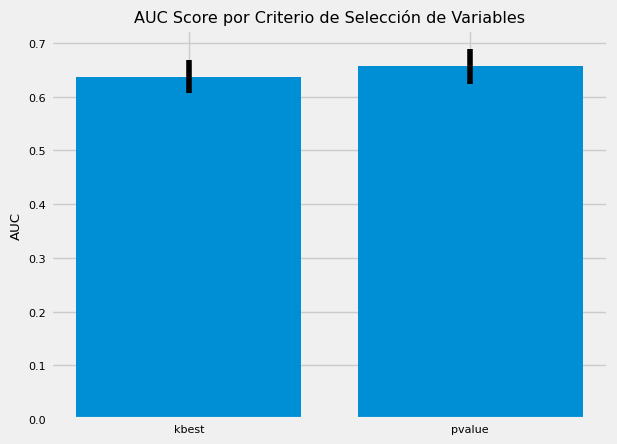

In [57]:
feature_selection_method = df_summary.groupby('select_features_criterion')[['train_roc_auc_score','val_roc_auc_score']].agg(['mean', 'std'])

fig, ax = plt.subplots(1,1) 

ax.bar(x=feature_selection_method.index, height=feature_selection_method['val_roc_auc_score']['mean'],
       yerr=feature_selection_method['val_roc_auc_score']['std'])
ax.set_title('AUC Score por Criterio de Selección de Variables')
ax.set_ylabel('AUC')
plt.show()

In [66]:
feature_selection_method

train_roc_auc_score           val_roc_auc_score  \
                                         mean       std              mean   
select_features_criterion                                                   
kbest                                0.643076  0.027299          0.636525   
pvalue                               0.671025  0.030632          0.655858   

                                     
                                std  
select_features_criterion            
kbest                      0.030755  
pvalue                     0.032800

In [64]:
ttest_ind(
    df_summary.query('select_features_criterion == "kbest"')['val_roc_auc_score'],
    df_summary.query('select_features_criterion == "pvalue"')['val_roc_auc_score'],
)

Ttest_indResult(statistic=-5.078702073683506, pvalue=6.127127705127565e-07)

In [ ]:
fig, ax = plt.subplots(1,1) 

ax.bar(x=score_summary_group.index, height=score_summary_group['train_roc_auc_score']['mean'], yerr=score_summary_group['train_roc_auc_score']['std'])
ax.set_title('Cantidad de Promedio de Registros por Día de la Semana')
ax.set_ylabel('Cantidad Promedio de Registros')
plt.show()

In [45]:
score_summary_group = df_summary.groupby('modelo')[['train_roc_auc_score','val_roc_auc_score']].agg(['mean', 'std'])
score_summary_group

train_roc_auc_score           val_roc_auc_score  \
                                      mean       std              mean   
modelo                                                                   
DecisionTreeClassifier            0.627919  0.015838          0.618996   
LogisticRegression                0.653511  0.026392          0.650074   
RandomForestClassifier            0.668760  0.031985          0.655004   

                                  
                             std  
modelo                            
DecisionTreeClassifier  0.020891  
LogisticRegression      0.032034  
RandomForestClassifier  0.030390

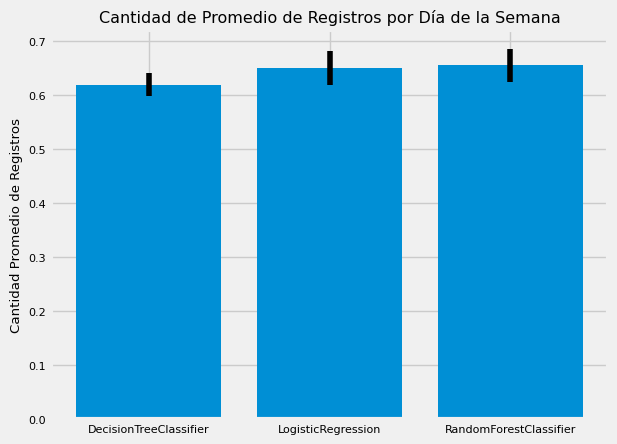

In [67]:
fig, ax = plt.subplots(1,1) 

ax.bar(x=score_summary_group.index, height=score_summary_group['val_roc_auc_score']['mean'], yerr=score_summary_group['val_roc_auc_score']['std'])
ax.set_title('Cantidad de Promedio de Registros por Día de la Semana')
ax.set_ylabel('Cantidad Promedio de Registros')
plt.show()

In [73]:
combinacion_temporadas = [x for x in combinations(df_summary['modelo'].unique(), 2)]

for x in combinacion_temporadas:
    
    modelo_x = x[0]
    modelo_y = x[1]
    
    score_modelo_x = df_summary.query(f'modelo == "{modelo_x}"')['val_roc_auc_score']
    score_modelo_y = df_summary.query(f'modelo == "{modelo_y}"')['val_roc_auc_score']
    
    t_stat, t_pvalue = ttest_ind(score_modelo_x, score_modelo_y)
    
    print(f'Temporada {modelo_x} - Temporada {modelo_y} -> (stat: {t_stat:f}, pvalue: {t_pvalue:f})')

Temporada LogisticRegression - Temporada DecisionTreeClassifier -> (stat: 8.901925, pvalue: 0.000000)
Temporada LogisticRegression - Temporada RandomForestClassifier -> (stat: -1.222936, pvalue: 0.222563)
Temporada DecisionTreeClassifier - Temporada RandomForestClassifier -> (stat: -10.695900, pvalue: 0.000000)


### Comparativa Final

In [79]:
df_summary

,best_params,select_features_criterion,n_features,train_roc_auc_score,val_roc_auc_score,modelo
0,"{'solver': 'liblinear', 'random_state': 202302...",kbest,10,0.556597,0.569124,LogisticRegression
1,"{'solver': 'liblinear', 'random_state': 202302...",kbest,30,0.656596,0.675973,LogisticRegression
2,"{'solver': 'liblinear', 'random_state': 202302...",kbest,50,0.670265,0.686101,LogisticRegression
3,"{'solver': 'liblinear', 'random_state': 202302...",pvalue,66,0.673195,0.689098,LogisticRegression
4,"{'solver': 'liblinear', 'random_state': 202302...",kbest,10,0.626697,0.664152,LogisticRegression
...,...,...,...,...,...,...
355,"{'random_state': 20230214, 'n_estimators': 100...",pvalue,65,0.704930,0.651289,RandomForestClassifier
356,"{'random_state': 20230214, 'n_estimators': 100...",kbest,10,0.621702,0.627412,RandomForestClassifier
357,"{'random_state': 20230214, 'n_estimators': 100...",kbest,30,0.661574,0.666863,RandomForestClassifier
358,"{'random_state': 20230214, 'n_estimators': 100...",kbest,50,0.689930,0.686719,RandomForestClassifier


In [104]:
best_params = {}

for model in df_summary['modelo'].unique():
    
    best_id = df_summary.query(f'(modelo == "{model}") & (select_features_criterion == "pvalue")')['val_roc_auc_score'].idxmax()
    
    best_param = df_summary.loc[best_id, 'best_params']
    
    best_params[model] = best_param

In [105]:
best_params

{'LogisticRegression': {'solver': 'liblinear',
  'random_state': 20230214,
  'penalty': 'l1',
  'fit_intercept': True,
  'C': 1000.0},
 'DecisionTreeClassifier': {'max_features': 'sqrt',
  'max_depth': 10,
  'criterion': 'entropy'},
 'RandomForestClassifier': {'random_state': 20230214,
  'n_estimators': 100,
  'max_features': 'sqrt',
  'max_depth': 10,
  'criterion': 'gini'}}

In [122]:
## TRATAMIENTO DE VARIABLES CATEGÓRICAS
# Genera Variables Dummy por cada categoría y elimina la primera categoría de cada variable
# La eliminación de la primera categoría se ha para evitar problemas de multicolinealidad.
encoder = OneHotEncoder(drop='first', sparse_output=False, min_frequency=100, handle_unknown='infrequent_if_exist')
encoder.fit(X_train)

# Transformación de matrix X -> Dummies
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Renombrar Columnas (para interpretabilidad)
X_train = pd.DataFrame(X_train, columns=encoder.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=encoder.get_feature_names_out())

In [124]:
chi2_features = SelectKBest(chi2, k=50)
chi2_features.fit(X_train, y_train)

chi2_results = pd.DataFrame({'variable' : chi2_features.feature_names_in_,
                             'score'    : chi2_features.scores_,
                             'pvalue'   : chi2_features.pvalues_})

chi2_results.set_index('variable', inplace=True)

variables_significativas = list(chi2_results.query('pvalue < 0.05').index)

X_train_pvalue = X_train[variables_significativas]
X_test_pvalue = X_test[variables_significativas]

In [132]:
lr_final = LogisticRegression()
lr_final.set_params(**best_params['LogisticRegression'])

dt_final = DecisionTreeClassifier()
dt_final.set_params(**best_params['DecisionTreeClassifier'])

rf_final = RandomForestClassifier()
rf_final.set_params(**best_params['RandomForestClassifier'])

RandomForestClassifier(max_depth=10, random_state=20230214)

In [133]:
lr_final.fit(X_train_pvalue, y_train)
dt_final.fit(X_train_pvalue, y_train)
rf_final.fit(X_train_pvalue, y_train)

RandomForestClassifier(max_depth=10, random_state=20230214)

In [135]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_y_pred = lr_final.predict_proba(X_test_pvalue)
dt_y_pred = dt_final.predict_proba(X_test_pvalue)
rf_y_pred = rf_final.predict_proba(X_test_pvalue)

fpr_lr, tpr_lr, th_lr = roc_curve(y_test, lr_y_pred[:,1])
auc_lr = roc_auc_score(y_test, lr_y_pred[:,1])

fpr_dt, tpr_dt, th_dt = roc_curve(y_test, dt_y_pred[:,1])
auc_dt = roc_auc_score(y_test, dt_y_pred[:,1])

fpr_rf, tpr_rf, th_rf = roc_curve(y_test, rf_y_pred[:,1])
auc_rf = roc_auc_score(y_test, rf_y_pred[:,1])

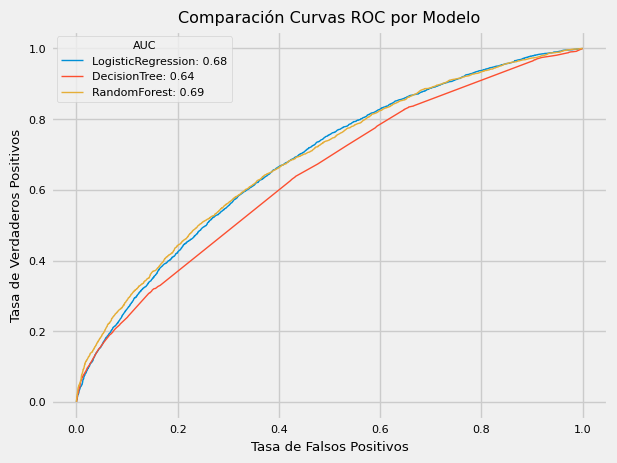

In [138]:
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression: {}'.format(str(round(auc_lr,2))), linewidth=1)
plt.plot(fpr_dt, tpr_dt, label='DecisionTree: {}'.format(str(round(auc_dt,2))), linewidth=1)
plt.plot(fpr_rf, tpr_rf, label='RandomForest: {}'.format(str(round(auc_rf,2))), linewidth=1)
plt.title('Comparación Curvas ROC por Modelo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(title='AUC')
plt.show()